# import Library 
- ### Hello ,We will develop a Convolutional Neural Network (CNN) model to analyze and classify images from our lung dataset.


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

import cv2 # open cv
import os 

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [2]:
import os

# Dizin yolunu belirtin
train_path = r'C:\Users\Sabri\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray'

# Klasör içeriğini kontrol et
if os.path.exists(train_path):
    print("Dizin mevcut. İçeriği kontrol ediliyor...")
    for label in os.listdir(train_path):
        label_path = os.path.join(train_path, label)
        if os.path.isdir(label_path):  # Sadece klasörleri kontrol et
            print(f"'{label}' klasörü: {os.listdir(label_path)}")
else:
    print("Dizin mevcut değil.")

Dizin mevcut. İçeriği kontrol ediliyor...
'chest_xray' klasörü: ['.DS_Store', 'test', 'train', 'val']
'test' klasörü: ['NORMAL', 'PNEUMONIA']
'train' klasörü: ['NORMAL', 'PNEUMONIA']
'val' klasörü: ['NORMAL', 'PNEUMONIA']
'__MACOSX' klasörü: ['._chest_xray', 'chest_xray']


# Load Data


In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150  # image size

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)  # Folder path 
        class_num = labels.index(label)  # 'PNEUMONIA' -> 0, 'NORMAL' -> 1
        
        for img in tqdm(os.listdir(path)):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            if img_arr is None:
                print(f'Error reading image: {img}')
                continue
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, class_num])
            
    return np.array(data, dtype=object)  # Fixed

def get_train_data(train_path):
    print("Uploading training data...")
    return get_data(train_path)

def get_test_data(test_path):
    print("Uploading test data...")
    return get_data(test_path)

def get_val_data(val_path):
    print("Uploading validation data...")
    return get_data(val_path)

# Usage 
train_path = r'C:\Users\Sabri\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\train'
test_path = r'C:\Users\Sabri\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\test'
val_path = r'C:\Users\Sabri\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\val'

train_data = get_train_data(train_path)
test_data = get_test_data(test_path)
val_data = get_val_data(val_path)

print("Train : ", train_data.shape, "\n", 'Validation : ', val_data.shape, "\n", 'Test : ', test_data.shape)

Uploading training data...


  0%|▏                                                                              | 11/3876 [00:00<00:35, 109.30it/s]

Error reading image: .DS_Store


  1%|▍                                                                                | 7/1342 [00:00<00:19, 67.98it/s]

Error reading image: .DS_Store


100%|██████████████████████████████████████████████████████████████████████████████| 1342/1342 [00:22<00:00, 58.92it/s]


Uploading test data...


100%|███████████████████████████████████████████████████████████████████████████████| 234/234 [00:02<00:00, 110.41it/s]


Uploading validation data...


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 238.17it/s]


Error reading image: .DS_Store


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 122.07it/s]

Error reading image: .DS_Store
Train :  (5216, 2) 
 Validation :  (16, 2) 
 Test :  (624, 2)


In [4]:
# let's mix our data so that we don't have problems in the future
np.random.shuffle(train_data)
np.random.shuffle(val_data)
np.random.shuffle(test_data)

# Data visualization and preprocessing

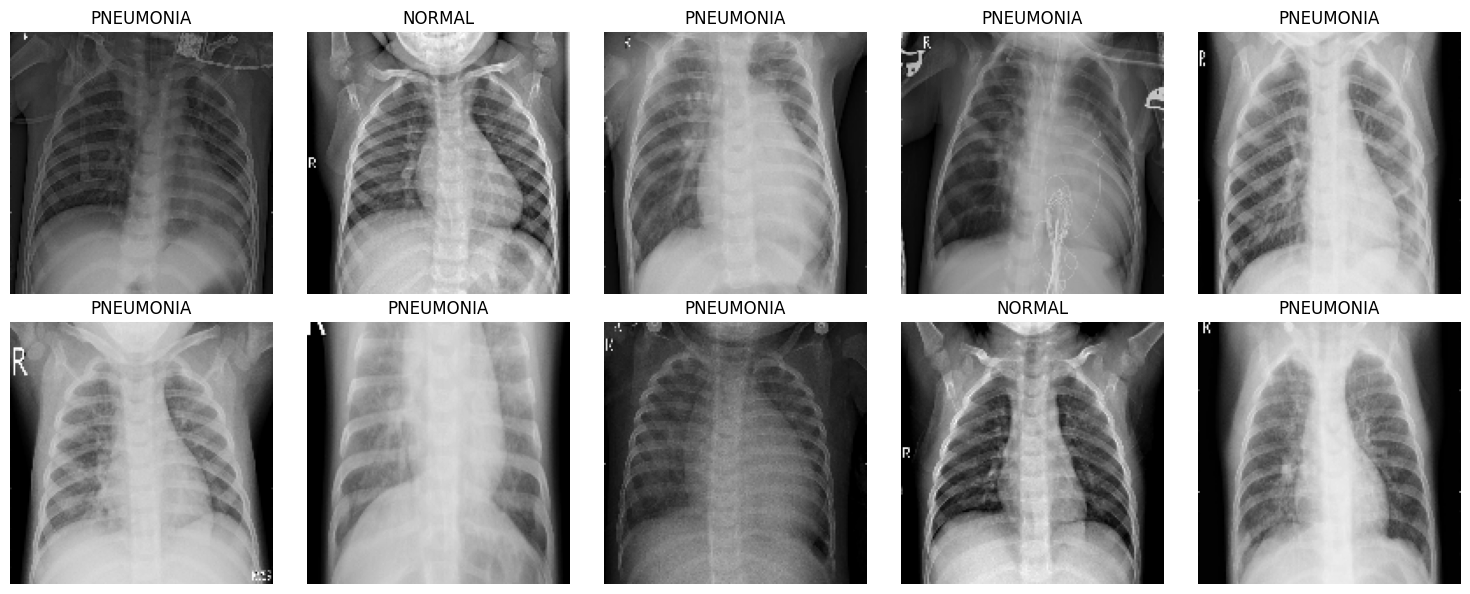

In [5]:
import random 
def display_random_samples(data, num_samples=10):
    plt.figure(figsize=(15, 6))
    
    random_samples = random.sample(list(data), num_samples) 
    
    for i, (img, label) in enumerate(random_samples):
        plt.subplot(2, 5, i + 1)   # 2 rows, 5 columns
        plt.imshow(img, cmap='gray')
        plt.title(labels[label])  
        plt.axis('off')  
    plt.tight_layout()
    plt.show()
    
display_random_samples(train_data, num_samples=10)

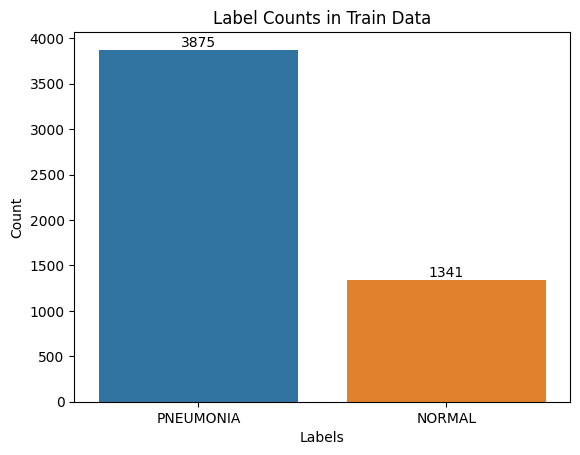

In [6]:
l=[]
for i in train_data :
    if(i[1]==0):
        l.append('PNEUMONIA')
    else:
        l.append('NORMAL')
#sns.countplot(x=l)

ax = sns.countplot(x=l)

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.title('Label Counts in Train Data')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

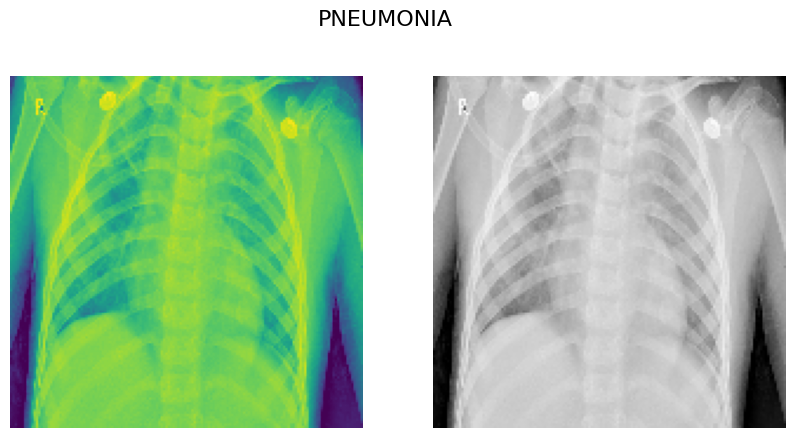

In [7]:
x_train = []
x_test = []
x_val = []

y_train = []
y_test = []
y_val = []

for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val_data:
    x_val.append(feature)
    y_val.append(label)
    
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(x_train[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(x_train[0], cv2.COLOR_GRAY2RGB))
plt.axis('off')

plt.suptitle(labels[y_train[0]], fontsize=16)
plt.show()

In [8]:
x_train[1]

array([[ 3,  2,  1, ..., 36, 21, 11],
       [ 1,  0,  0, ..., 45, 29, 12],
       [ 0,  0,  1, ..., 46, 36, 20],
       ...,
       [15, 14, 14, ..., 10, 10, 10],
       [15, 15, 14, ..., 11, 10, 10],
       [15, 14, 14, ..., 12, 10, 10]], dtype=uint8)

- ## We will normalize the values from 0 to 255 and bring them to the range of 0 and 1 so that the model will learn better and faster.

In [9]:
# Normalization [0 , 255]   / 255 = [0,1]
x_train=np.array(x_train)/255
x_test=np.array(x_test)/255
x_val=np.array(x_val)/255

# (5216 ,150 ,150) --> (5216 ,150 ,150 ,1) for Deeplearning
## Additional Dimension: The last dimension, 1, indicates that images are single channel (grayscale). Color images typically have three channels (RGB), while grayscale images have a single channel.

x_train=x_train.reshape(-1,img_size,img_size,1)  # channel 1 ->(grey)
x_test=x_test.reshape(-1,img_size,img_size,1)
x_val=x_val.reshape(-1,img_size,img_size,1)

y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

# Data agumentation

- ### to increase generalization we resort to data augmentation 

In [18]:
print('befor :',x_train.shape)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,  # Set input mean to 0 over the dataset
    samplewise_center=False,    # Set each sample mean to 0
    featurewise_std_normalization=False,  # Divide inputs by std of the dataset
    samplewise_std_normalization=False,   # Divide each sample by its std
    zca_whitening=False,        # Apply ZCA whitening
    rotation_range=30,          # Randomly rotate images in the range (degrees)
    zoom_range=0.2,             # Randomly zoom into images
    width_shift_range=0.1,      # Randomly shift images horizontally
    height_shift_range=0.1,     # Randomly shift images vertically
    horizontal_flip=True,       # Randomly flip images horizontally
    vertical_flip=True          # Randomly flip images vertically
)
datagen.fit(x_train)

print('Now :' ,x_train.shape)

(5216, 150, 150, 1)

# Create deep learning model and train 


In [17]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(128, (7,7), strides=1, padding="same", activation="relu", input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding="same"))

model.add(Conv2D(64, (5,5), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding="same"))

model.add(Conv2D(32, (3,3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding="same"))

model.add(Flatten())
model.add(Dense(units = 128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 128)       │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 150, 150, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 38, 38, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 38, 38, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 19, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 11552)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,478,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,537 (6.52 MB)

 Trainable params: 1,709,089 (6.52 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
epoch_number = 20
history=model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=epoch_number, validation_data=datagen.flow(x_test, y_test),callbacks=[learning_rate_reduction])

print("loss of model : ",model.evaluate(x_test,y_test)[0])
print("Accuracy of model : ",model.evaluate(x_test,y_test)[1]*100)

Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 854ms/step - accuracy: 0.7434 - loss: 1.0092 - val_accuracy: 0.6250 - val_loss: 11.1204 - learning_rate: 0.0010
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 811ms/step - accuracy: 0.8545 - loss: 0.3494 - val_accuracy: 0.6250 - val_loss: 8.5467 - learning_rate: 0.0010
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.8803 - loss: 0.2913
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 842ms/step - accuracy: 0.8802 - loss: 0.2914 - val_accuracy: 0.6250 - val_loss: 11.4280 - learning_rate: 0.0010
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.6001 - loss: 7.8622
loss of model :  7.093970775604248
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.6001 - loss: 7.8622
Accuracy of model :  62.5


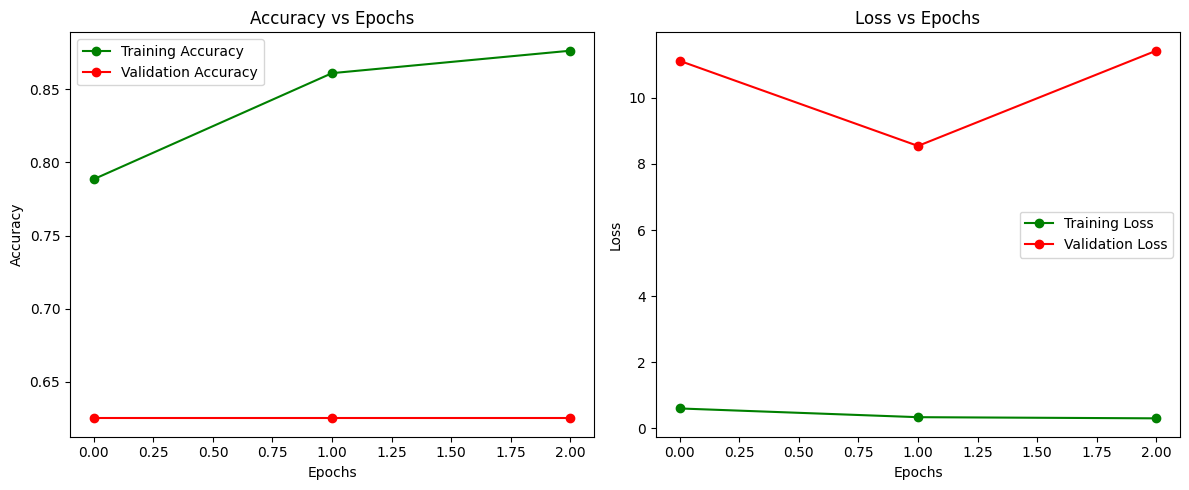

In [19]:
import matplotlib.pyplot as plt

epochs = [i for i in range(epoch_number)]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs Epochs')

ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss vs Epochs')

plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step


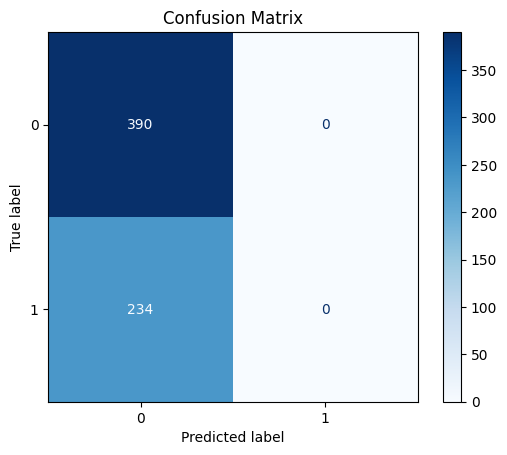

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       390
           1       0.00      0.00      0.00       234

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) 


y_true = np.array(y_test)
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes))


new : https://www.kaggle.com/code/metinhsimimi/pneumonia-cnn-and-agumentation/edit  